[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kevin7261/Geographic-Data-Science-with-Python/blob/main/全域空間自相關.ipynb)

# 全域空間自相關

## [1] 上傳資料

In [1]:
# @title <介面> 上傳geojson檔案

from google.colab import files
import os

def upload_geojson():
  print("請選擇要上傳的 geojson 檔案。若上傳同名檔案，將會自動覆寫。")
  uploaded = files.upload()
  for uploaded_filename in uploaded.keys():
    if uploaded_filename.endswith('.geojson'):
      # 檢查是否需要處理 Colab 自動重新命名的情況
      if uploaded_filename.endswith(').geojson'):
          # 嘗試找出原始檔名
          original_filename = uploaded_filename.rsplit('(', 1)[0].strip() + '.geojson'
          if os.path.exists(original_filename):
              os.remove(original_filename) # 刪除舊檔案
              print(f"Existing file '{original_filename}' overwritten.")
          # 將上傳的檔案重新命名為原始檔名
          os.rename(uploaded_filename, original_filename)
          print(f"已將 '{uploaded_filename}' 重新命名為 '{original_filename}'")
          return original_filename # 返回原始檔名
      else:
         # 如果沒有被自動重新命名，直接返回上傳的檔名
         print(f"已上傳檔案：{uploaded_filename}")
         return uploaded_filename

  print("沒有上傳有效的 geojson 檔案。")
  return None # 沒有上傳或上傳的不是 geojson

FILE_NAME_GEOJSON = upload_geojson()
print("實際檔名：", FILE_NAME_GEOJSON)

請選擇要上傳的 geojson 檔案。若上傳同名檔案，將會自動覆寫。


Saving 台南市區.geojson to 台南市區.geojson
已上傳檔案：台南市區.geojson
實際檔名： 台南市區.geojson


In [2]:
# @title <介面> 上傳xlsx檔案

from google.colab import files
import os

def upload_xlsx():
  print("請選擇要上傳的 xlsx 檔案。若上傳同名檔案，將會自動覆寫。")
  uploaded = files.upload()
  for uploaded_filename in uploaded.keys():
    if uploaded_filename.endswith('.xlsx'):
      # 檢查是否需要處理 Colab 自動重新命名的情況
      if uploaded_filename.endswith(').xlsx'):
          # 嘗試找出原始檔名
          original_filename = uploaded_filename.rsplit('(', 1)[0].strip() + '.xlsx'
          if os.path.exists(original_filename):
              os.remove(original_filename) # 刪除舊檔案
              print(f"Existing file '{original_filename}' overwritten.")
          # 將上傳的檔案重新命名為原始檔名
          os.rename(uploaded_filename, original_filename)
          print(f"已將 '{uploaded_filename}' 重新命名為 '{original_filename}'")
          return original_filename # 返回原始檔名
      else:
         # 如果沒有被自動重新命名，直接返回上傳的檔名
         print(f"已上傳檔案：{uploaded_filename}")
         return uploaded_filename

  print("沒有上傳有效的 xlsx 檔案。")
  return None # 沒有上傳或上傳的不是 xlsx

FILE_NAME_XLSX = upload_xlsx()
print("實際檔名：", FILE_NAME_XLSX)

請選擇要上傳的 xlsx 檔案。若上傳同名檔案，將會自動覆寫。


Saving 15_台南市區_合併位置.xlsx to 15_台南市區_合併位置.xlsx
已上傳檔案：15_台南市區_合併位置.xlsx
實際檔名： 15_台南市區_合併位置.xlsx


## [2] 初始設定

In [3]:
# @title 專案設定

PROJECT_NAME = "15_台南市區_合併位置"
WORKSHEET_NAME = "15_台南市區_合併位置"
WORKSHEET_NAME_TIME = "15_台南市區_合併位置_時間"
ANALYSIS_FIELD_NAME = "count"
ANALYSIS_FIELD_NAME_TIME = "onset_month"
ANALYSIS_FIELD_NAME_LAG = f"{ANALYSIS_FIELD_NAME}_lag"
ANALYSIS_FIELD_NAME_BINARY = f"{ANALYSIS_FIELD_NAME}_binary"
ANALYSIS_FIELD_NAME_STD = f"{ANALYSIS_FIELD_NAME}_std"
ANALYSIS_FIELD_NAME_LAG_STD = f"{ANALYSIS_FIELD_NAME}_lag_std"

In [4]:
# @title 安裝套件

!pip install -q geopandas gdown
!pip install -q pysal splot contextily
!pip install -q ipywidgets

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.8/142.8 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.7/286.7 kB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 57.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.6/141.6 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.9/53.9 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.1/243.1 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 389.9/389.9 kB 21.3 MB/s eta 0:00:00
   ━━━━

In [5]:
# @title 下載台北思源黑體

# 下載台北思源黑體，並隱藏輸出
!wget -q -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download

# 匯入必要的庫
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.font_manager import fontManager

# 新增字體
fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')

# 設定字體
mpl.rc('font', family='Taipei Sans TC Beta')


In [6]:
# @title 匯入函式庫

# Graphics
import matplotlib.pyplot as plt
import seaborn
from pysal.viz import splot
from splot.esda import plot_moran
import contextily

# Analysis
import geopandas
import pandas
from pysal.explore import esda
from pysal.lib import weights
from numpy.random import seed

/usr/local/lib/python3.11/dist-packages/spaghetti/network.py:41: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)


## [3] 資料處理

### 載入資料

In [7]:
# @title 載入geojson

lads = geopandas.read_file(
    FILE_NAME_GEOJSON,
).set_index("CODEBASE")
#lads.info()

#print(lads.crs) # EPSG:4979 Geodetic 3D coordinate system

lads.set_crs(epsg=3826, inplace=True, allow_override=True) # EPSG:3826 TWD97

#print(lads.crs)

,U_ID,CODE1,CODE2,TOWN_ID,TOWN,COUNTY_ID,COUNTY,X,Y,AREA,H_CNT,P_CNT,M_CNT,F_CNT,INFO_TIME,geometry
CODEBASE,,,,,,,,,,,,,,,,
A6733-0874-00,5144.0,A6733-43-012,A6733-43,67000330,南區,67000,臺南市,166173.68829,2.535589e+06,25735.24733,91,282,151,131,112Y06M,"POLYGON Z ((166321.261 2535692.982 0, 166319 2..."
A6733-0878-00,5145.0,A6733-44-006,A6733-44,67000330,南區,67000,臺南市,165894.50162,2.535469e+06,73573.78885,19,72,37,35,112Y06M,"POLYGON Z ((165968.38 2535639.042 0, 165978.83..."
A6733-0876-00,5146.0,A6733-43-012,A6733-43,67000330,南區,67000,臺南市,166225.66291,2.535524e+06,20277.53652,24,67,36,31,112Y06M,"POLYGON Z ((166317.999 2535628.685 0, 166318.5..."
A6732-0998-00,4736.0,A6732-60-005,A6732-60,67000320,東區,67000,臺南市,171121.76303,2.540747e+06,12151.50679,102,294,141,153,112Y06M,"POLYGON Z ((171065.623 2540812.968 0, 171117.3..."
A6733-0546-00,4737.0,A6733-28-006,A6733-28,67000330,南區,67000,臺南市,166383.53981,2.540732e+06,24429.37370,0,0,0,0,112Y06M,"POLYGON Z ((166306.724 2540811.815 0, 166306.9..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
A6735-0775-00,779.0,A6735-38-005,A6735-38,67000350,安南區,67000,臺南市,166362.71262,2.549375e+06,19304.15704,42,129,59,70,112Y06M,"POLYGON Z ((166374.559 2549491.189 0, 166412.8..."
A6735-0759-00,780.0,A6735-26-005,A6735-26,67000350,安南區,67000,臺南市,167484.42419,2.549441e+06,7543.19820,44,133,66,67,112Y06M,"POLYGON Z ((167445.095 2549487.087 0, 167548.8..."
A6735-0769-00,781.0,A6735-30-005,A6735-30,67000350,安南區,67000,臺南市,166722.60054,2.549380e+06,14166.79920,40,107,57,50,112Y06M,"POLYGON Z ((166805.218 2549471.521 0, 166790.3..."


In [8]:
# @title 載入xlsx

ref = pandas.read_excel(FILE_NAME_XLSX, sheet_name=WORKSHEET_NAME).set_index("name")
ref_time = pandas.read_excel(FILE_NAME_XLSX, sheet_name=WORKSHEET_NAME_TIME).set_index("name")

ref
ref_time

#ref.head()

,onset_month,latitude,longitude,x,y,count
name,,,,,,
A6732-0537-00,1,22.983094,120.240693,172150.460973,2.542612e+06,1
A6732-0326-00,1,22.987333,120.242619,172350.349308,2.543081e+06,1
A6732-0116-00,2,22.993666,120.213989,169418.731180,2.543798e+06,1
A6733-0774-00,4,22.937317,120.190003,166925.126109,2.537571e+06,1
A6734-0240-00,5,23.012956,120.209773,168998.004660,2.545936e+06,2
...,...,...,...,...,...,...
A6732-0208-00,12,22.990084,120.229083,170964.107678,2.543393e+06,1
A6732-0056-00,12,22.996288,120.232219,171289.195615,2.544078e+06,1
A6732-0010-00,12,22.999388,120.228782,170938.665759,2.544423e+06,1


In [9]:
# @title 用index欄位合併xlsx與geojson

db = (
    geopandas.GeoDataFrame(
        lads.join(ref[[ANALYSIS_FIELD_NAME]]), crs=lads.crs
    )
    .to_crs(epsg=3857)[ # EPSG:3857 Spherical Mercator
        [ANALYSIS_FIELD_NAME, "P_CNT", "geometry"]
    ]
    #.dropna()
)

#db.info()

# @title 空值填0
db[ANALYSIS_FIELD_NAME] = db[ANALYSIS_FIELD_NAME].fillna(0)

db["onset_ratio"] = 0.0
mask = (db["P_CNT"] > 0) & (db[ANALYSIS_FIELD_NAME] > 0)
db.loc[mask, "onset_ratio"] = (
    db.loc[mask, ANALYSIS_FIELD_NAME] / db.loc[mask, "P_CNT"]
).mul(100)  # ✅ 成為百分比形式

In [10]:
# @title 用index欄位合併xlsx與geojson (時間)

db_time = (
    geopandas.GeoDataFrame(
        lads.join(ref_time[[ANALYSIS_FIELD_NAME, ANALYSIS_FIELD_NAME_TIME]]), crs=lads.crs
    )
    .to_crs(epsg=3857)[ # EPSG:3857 Spherical Mercator
        [ANALYSIS_FIELD_NAME, ANALYSIS_FIELD_NAME_TIME, "P_CNT", "geometry"]
    ]
    #.dropna()
)

#db_time.info()

# @title 空值填0
db_time[ANALYSIS_FIELD_NAME] = db_time[ANALYSIS_FIELD_NAME].fillna(0)
db_time[ANALYSIS_FIELD_NAME_TIME] = db_time[ANALYSIS_FIELD_NAME_TIME].fillna(0)

db_time["onset_ratio"] = 0.0
mask = (db_time["P_CNT"] > 0) & (db_time[ANALYSIS_FIELD_NAME] > 0)
db_time.loc[mask, "onset_ratio"] = (
    db_time.loc[mask, ANALYSIS_FIELD_NAME] / db_time.loc[mask, "P_CNT"]
).mul(100)  # ✅ 成為百分比形式

### 繪製資料

In [11]:
# @title <介面> 繪製資料地圖（含動態控制分級級數欄位）

from ipywidgets import Dropdown, FloatSlider, Button, Output, VBox, RadioButtons, BoundedIntText
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import matplotlib
import contextily

# ✅ 所有可用色帶
all_colormaps = sorted(matplotlib.colormaps())

# ✅ 支援的分類法
available_schemes = [
    "equalinterval", "quantiles", "fisherjenks",
    "naturalbreaks", "headtailbreaks", "maxp", "boxplot"
]

# ✅ 欄位選擇器
field_selector = RadioButtons(
    options=["count", "P_CNT", "onset_ratio"],
    value="count",
    description="欄位選擇：",
    style={'description_width': 'initial'}
)

# ✅ 分級法下拉選單
scheme_widget = Dropdown(
    options=available_schemes,
    value="quantiles",
    description="分級方法：",
    style={'description_width': 'initial'}
)

# ✅ 色帶下拉選單
cmap_widget = Dropdown(
    options=all_colormaps,
    value="viridis",
    description="色帶：",
    style={'description_width': 'initial'}
)

# ✅ 分級級數欄位（可動態禁用）
k_widget = BoundedIntText(
    value=5,
    min=2,
    max=20,
    step=1,
    description='分級級數：',
    style={'description_width': 'initial'}
)

# ✅ 透明度控制
alpha_slider = FloatSlider(
    value=0.75,
    min=0.0,
    max=1.0,
    step=0.05,
    description='透明度：',
    readout_format='.2f',
    style={'description_width': 'initial'}
)

# ✅ 確定按鈕與輸出
execute_button = Button(
    description='確定',
    button_style='primary'
)

output_widget = Output()

# ✅ 顯示所有元件
display(VBox([
    field_selector,
    scheme_widget,
    cmap_widget,
    k_widget,
    alpha_slider,
    execute_button,
    output_widget
]))

# ✅ 動態禁用 k 欄位（根據分級法）
def on_scheme_change(change):
    unsupported_schemes = ["headtailbreaks", "maxp", "boxplot"]
    selected = change["new"]
    k_widget.disabled = selected in unsupported_schemes

# ✅ 綁定事件
scheme_widget.observe(on_scheme_change, names="value")
on_scheme_change({"new": scheme_widget.value})  # 初始執行一次

# ✅ 主繪圖邏輯
def on_button_clicked(b):
    selected_field = field_selector.value
    selected_scheme = scheme_widget.value
    selected_cmap = cmap_widget.value
    selected_alpha = alpha_slider.value
    selected_k = k_widget.value

    with output_widget:
        clear_output(wait=True)

        print(f"\n欄位：{selected_field}")
        print(f"分級方法: {selected_scheme}")
        print(f"色帶: {selected_cmap}")
        print(f"透明度: {selected_alpha}")
        print(f"分級級數: {selected_k if not k_widget.disabled else '自動'}")

        f, ax = plt.subplots(1, figsize=(9, 9))

        db[db[selected_field] == 0].plot(
            color="lightgray",
            edgecolor="white",
            linewidth=0.2,
            alpha=selected_alpha,
            ax=ax
        )

        kwargs = {
            "column": selected_field,
            "cmap": selected_cmap,
            "scheme": selected_scheme,
            "edgecolor": "white",
            "linewidth": 0.2,
            "alpha": selected_alpha,
            "legend": True,
            "legend_kwds": {"loc": "upper left"},
            "ax": ax
        }

        if not k_widget.disabled:
            kwargs["k"] = selected_k

        db[db[selected_field] > 0].plot(**kwargs)

        contextily.add_basemap(
            ax,
            crs=db.crs,
            source=contextily.providers.CartoDB.PositronNoLabels,
            zoom=13
        )

        ax.set_axis_off()
        ax.set_title(f"{selected_field}")

        plt.tight_layout()
        plt.show()

# ✅ 綁定按鈕事件
execute_button.on_click(on_button_clicked)

# ✅ 預設執行一次
on_button_clicked(None)


In [12]:
# @title <介面> 繪製資料地圖 (時間)

from ipywidgets import Dropdown, FloatSlider, Button, Output, VBox
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import matplotlib
import contextily
import mapclassify
import numpy as np
from matplotlib.patches import Patch
import time  # ✅ 為強制等待刷新畫面

# ✅ 所有可用 colormap 與分級法
all_colormaps = sorted(matplotlib.colormaps())
available_schemes = [
    "equalinterval", "quantiles", "fisherjenks",
    "naturalbreaks", "headtailbreaks"
]

# ✅ UI 元件
scheme_widget = Dropdown(
    options=available_schemes,
    value="quantiles",
    description="分級方法：",
    style={'description_width': 'initial'}
)

cmap_widget = Dropdown(
    options=all_colormaps,
    value="viridis",
    description="色帶：",
    style={'description_width': 'initial'}
)

alpha_slider = FloatSlider(
    value=0.75,
    min=0.0,
    max=1.0,
    step=0.05,
    description='透明度：',
    readout_format='.2f',
    style={'description_width': 'initial'}
)

execute_button = Button(
    description='確定',
    button_style='primary'
)

output_widget = Output()

# ✅ 顯示 UI
display(VBox([
    scheme_widget,
    cmap_widget,
    alpha_slider,
    execute_button,
    output_widget
]))

# ✅ 繪圖邏輯
def on_button_clicked(b):
    selected_scheme = scheme_widget.value
    selected_cmap = cmap_widget.value
    selected_alpha = alpha_slider.value

    # ✅ 第一步：先清空並顯示「繪製中...」
    with output_widget:
        clear_output(wait=True)
        display("⏳ 繪製中...")  # ✅ 強制顯示
    time.sleep(0.2)  # ✅ 等待一下，讓畫面有機會刷新（必要！）

    # ✅ 第二步：開始正式繪圖
    with output_widget:
        clear_output(wait=True)
        print(f"\n分級方法: {selected_scheme}")
        print(f"色帶: {selected_cmap}")
        print(f"透明度: {selected_alpha}")

        months = range(7, 13)
        db_plot = db_time.to_crs(epsg=3857).copy()
        db_plot["value"] = 0
        for month in months:
            mask = db_plot["onset_month"] == month
            db_plot.loc[mask, "value"] = (
                db_plot.loc[mask, ANALYSIS_FIELD_NAME]
                .fillna(0).astype(int)
            )

        values = db_plot["value"]
        nonzero_values = values[values > 0]

        if len(nonzero_values) == 0:
            print("⚠️ 無非0資料")
            return

        scheme_map = {
            "equalinterval": mapclassify.EqualInterval,
            "quantiles": mapclassify.Quantiles,
            "fisherjenks": mapclassify.FisherJenks,
            "naturalbreaks": mapclassify.NaturalBreaks,
            "headtailbreaks": mapclassify.HeadTailBreaks
        }

        k = min(5, len(np.unique(nonzero_values)))
        classifier = scheme_map[selected_scheme](nonzero_values, k=k)
        bins = classifier.bins
        cmap = plt.get_cmap(selected_cmap, len(bins))
        colors = [matplotlib.colors.to_hex(cmap(i)) for i in range(cmap.N)]

        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        axes = axes.flatten()

        for idx, month in enumerate(months):
            ax = axes[idx]
            ax.set_title(f"{month}月", fontsize=12)
            ax.set_axis_off()

            month_mask = db_plot["onset_month"] == month

            db_plot.plot(
                color="lightgray",
                edgecolor="white",
                linewidth=0.2,
                alpha=selected_alpha,
                ax=ax
            )

            for class_id in range(len(bins)):
                lower = bins[class_id - 1] if class_id > 0 else 0
                upper = bins[class_id]
                mask = month_mask & db_plot["value"].between(lower + 1, upper, inclusive="both")

                if mask.any():
                    db_plot[mask].plot(
                        color=colors[class_id],
                        edgecolor="white",
                        linewidth=0.2,
                        alpha=selected_alpha,
                        ax=ax
                    )

            contextily.add_basemap(
                ax, crs=db_plot.crs,
                source=contextily.providers.CartoDB.PositronNoLabels,
                zoom=13
            )

        legend_handles = [Patch(facecolor="lightgray", label="0")]
        lower = 0
        for idx, upper in enumerate(bins):
            label = f"{int(lower + 1)} - {int(upper)}"
            legend_handles.append(Patch(facecolor=colors[idx], label=label))
            lower = upper

        fig.legend(handles=legend_handles, loc='lower center', ncol=len(legend_handles), fontsize=10)
        plt.tight_layout(rect=[0, 0.05, 1, 1])
        plt.show()

# ✅ 綁定按鈕 + 初始繪製
execute_button.on_click(on_button_clicked)
on_button_clicked(None)


In [13]:
# @title <動畫> 繪製資料地圖 (時間)

import matplotlib.pyplot as plt
import matplotlib
import contextily
import mapclassify
import numpy as np
from matplotlib.patches import Patch
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import warnings

# ✅ 關閉警告
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib.font_manager")
warnings.filterwarnings("ignore", category=UserWarning, module="mapclassify")

# ✅ 使用可顯示中文的字型
matplotlib.rcParams['font.family'] = 'Taipei Sans TC Beta'

# ✅ 使用者參數
selected_scheme = "quantiles"
selected_cmap = "viridis"
selected_alpha = 0.75

# ✅ 資料準備
months = list(range(7, 13))  # 7~12 月
db_plot = db_time.to_crs(epsg=3857).copy()
db_plot["value"] = 0

for month in months:
    mask = db_plot["onset_month"] == month
    db_plot.loc[mask, "value"] = (
        db_plot.loc[mask, ANALYSIS_FIELD_NAME]
        .fillna(0).astype(int)
    )

# ✅ 分級與顏色
values = db_plot["value"]
nonzero_values = values[values > 0]
scheme_map = {
    "equalinterval": mapclassify.EqualInterval,
    "quantiles": mapclassify.Quantiles,
    "fisherjenks": mapclassify.FisherJenks,
    "naturalbreaks": mapclassify.NaturalBreaks,
    "headtailbreaks": mapclassify.HeadTailBreaks
}
k = min(5, len(np.unique(nonzero_values)))
classifier = scheme_map[selected_scheme](nonzero_values, k=k)
bins = classifier.bins
cmap = plt.get_cmap(selected_cmap, len(bins))
colors = [matplotlib.colors.to_hex(cmap(i)) for i in range(cmap.N)]

# ✅ 建立單張地圖畫布
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_axis_off()

# ✅ 動畫更新函式（每幀畫不同月份）
def update(frame):
    ax.clear()
    ax.set_axis_off()
    month = months[frame]
    ax.set_title(f"{month} 月", fontsize=14)

    month_mask = db_plot["onset_month"] == month

    db_plot.plot(
        color="lightgray",
        edgecolor="white",
        linewidth=0.2,
        alpha=selected_alpha,
        ax=ax
    )

    for class_id in range(len(bins)):
        lower = bins[class_id - 1] if class_id > 0 else 0
        upper = bins[class_id]
        mask = month_mask & db_plot["value"].between(lower + 1, upper, inclusive="both")

        if mask.any():
            db_plot[mask].plot(
                color=colors[class_id],
                edgecolor="white",
                linewidth=0.2,
                alpha=selected_alpha,
                ax=ax
            )

    contextily.add_basemap(
        ax, crs=db_plot.crs,
        source=contextily.providers.CartoDB.PositronNoLabels,
        zoom=13
    )

    fig.suptitle(f"動畫播放中：{month} 月", fontsize=16)

# ✅ 建立動畫（只畫一張圖）
anim = FuncAnimation(fig, update, frames=len(months), interval=1000, repeat=True)

# ✅ 顯示動畫
plt.close(fig)
HTML(anim.to_jshtml())


Output hidden; open in https://colab.research.google.com to view.

## [4] 開始分析

### Spatial lag

In [14]:
# @title <介面> 繪製原始值與Spatial Lag值

from ipywidgets import Dropdown, FloatSlider, IntText, Button, Output, VBox
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import matplotlib
import contextily
from libpysal import weights
from libpysal.weights import spatial_lag

# ✅ 色帶與分級選項
all_colormaps = sorted(matplotlib.colormaps())
available_schemes = [
    "equalinterval", "quantiles", "fisherjenks",
    "naturalbreaks", "headtailbreaks", "maxp", "boxplot"
]

# ✅ 最近鄰居數與轉換方式
knn_input = IntText(
    value=8,
    description='最近鄰居數：',
    style={'description_width': 'initial'}
)

transform_widget = Dropdown(
    options=[
        ("R - Row-standardized(行標準化)", "R"),
        ("B - Binary(0/1)", "B"),
        ("D - Inverse Distance(距離倒數)", "D"),
        ("U - Row-sum Unstandardized(原始加總)", "U"),
        ("V - Variance-stabilizing", "V"),
        ("O - Original(不處理)", "O")
    ],
    value="R",
    description="轉換方式：",
    style={'description_width': 'initial'}
)

# ✅ 其他元件
scheme_widget = Dropdown(
    options=available_schemes,
    value="quantiles",
    description="分級方法：",
    style={'description_width': 'initial'}
)

cmap_widget = Dropdown(
    options=all_colormaps,
    value="viridis",
    description="色帶：",
    style={'description_width': 'initial'}
)

alpha_slider = FloatSlider(
    value=0.75,
    min=0.0,
    max=1.0,
    step=0.05,
    description='透明度：',
    readout_format='.2f',
    style={'description_width': 'initial'}
)

execute_button = Button(
    description='確定',
    button_style='primary'
)

output_widget = Output()

# ✅ 顯示 UI（順序調整：k、transform 放最上）
display(VBox([
    knn_input,
    transform_widget,
    scheme_widget,
    cmap_widget,
    alpha_slider,
    execute_button,
    output_widget
]))

# ✅ 點擊繪圖
def on_button_clicked(b):
    selected_scheme = scheme_widget.value
    selected_cmap = cmap_widget.value
    selected_alpha = alpha_slider.value
    selected_k = knn_input.value
    selected_transform = transform_widget.value

    with output_widget:
        clear_output(wait=True)

        print(f"\n使用的最近鄰居數：{selected_k}")
        print(f"使用的轉換方式：{selected_transform}")
        print(f"使用的分級方法：{selected_scheme}")
        print(f"使用的色帶：{selected_cmap}")
        print(f"透明度設定：{selected_alpha}")

        # ✅ 建立空間權重矩陣 w 並計算滯後值
        w = weights.KNN.from_dataframe(db, k=selected_k)
        w.transform = selected_transform
        db[ANALYSIS_FIELD_NAME_LAG] = spatial_lag.lag_spatial(w, db[ANALYSIS_FIELD_NAME])

        # ✅ 繪製地圖
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))

        db.plot(
            column=ANALYSIS_FIELD_NAME,
            cmap=selected_cmap,
            scheme=selected_scheme,
            k=5,
            edgecolor="white",
            linewidth=0.2,
            alpha=selected_alpha,
            legend=True,
            legend_kwds={"loc": "upper left"},
            ax=ax1,
        )
        contextily.add_basemap(
            ax1,
            crs=db.crs,
            source=contextily.providers.CartoDB.PositronNoLabels,
            zoom=13
        )
        ax1.set_axis_off()
        ax1.set_title(f"{ANALYSIS_FIELD_NAME}")

        db.plot(
            column="count_lag",
            cmap=selected_cmap,
            scheme=selected_scheme,
            k=5,
            edgecolor="white",
            linewidth=0.2,
            alpha=selected_alpha,
            legend=True,
            legend_kwds={"loc": "upper left"},
            ax=ax2,
        )
        contextily.add_basemap(
            ax2,
            crs=db.crs,
            source=contextily.providers.CartoDB.PositronNoLabels,
            zoom=13
        )
        ax2.set_axis_off()
        ax2.set_title(f"{ANALYSIS_FIELD_NAME} - Spatial Lag (k={w.k}, transform={w.transform})")

        plt.tight_layout()
        plt.show()

# ✅ 綁定事件
execute_button.on_click(on_button_clicked)
on_button_clicked(None)


### Binary case

In [15]:
# @title <介面> 輸入二元分隔值並計算Join Counts

from ipywidgets import IntText, Dropdown, FloatSlider, Button, Output, VBox, HBox, HTML
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import matplotlib
import contextily
from libpysal import weights
from esda.join_counts import Join_Counts
from numpy.random import seed

# ✅ 色帶與透明度選項
all_colormaps = sorted(matplotlib.colormaps())

cmap_widget = Dropdown(
    options=all_colormaps,
    value="Set3",
    description="色帶：",
    style={'description_width': 'initial'}
)

alpha_slider = FloatSlider(
    value=0.75,
    min=0.0,
    max=1.0,
    step=0.05,
    description='透明度：',
    readout_format='.2f',
    style={'description_width': 'initial'}
)

# ✅ 分隔值與鄰居數選項
count_range = (db[ANALYSIS_FIELD_NAME].min(), db[ANALYSIS_FIELD_NAME].max())
default_binary_value = int((count_range[0] + count_range[1]) / 2)

binary_input = IntText(
    value=default_binary_value,
    description='分隔值：',
    style={'description_width': 'initial'}
)
range_display = HTML(value=f"({int(count_range[0])} - {int(count_range[1])})")

knn_input = IntText(
    value=8,
    description='最近鄰居數：',
    style={'description_width': 'initial'}
)

transform_widget = Dropdown(
    options=[
        ("R - Row-standardized(行標準化)", "R"),
        ("B - Binary(0/1)", "B"),
        ("D - Inverse Distance(距離倒數)", "D"),
        ("U - Row-sum Unstandardized(原始加總)", "U"),
        ("V - Variance-stabilizing", "V"),
        ("O - Original(不處理)", "O")
    ],
    value="O",
    description="轉換方式：",
    style={'description_width': 'initial'}
)

# ✅ 執行按鈕與輸出
execute_button = Button(
    description='確定',
    button_style='primary'
)

output_widget = Output()

# ✅ 顯示介面
display(VBox([
    HBox([binary_input, range_display]),
    knn_input,
    transform_widget,
    cmap_widget,
    alpha_slider,
    execute_button,
    output_widget
]))

# ✅ 主分析函式
def on_execute_click(b):
    binary_value = binary_input.value
    selected_k = knn_input.value
    selected_transform = transform_widget.value
    selected_cmap = cmap_widget.value
    selected_alpha = alpha_slider.value

    with output_widget:
        clear_output(wait=True)

        # -----------------------------------------------

        print(f"\n分隔值：{binary_value}")
        print(f"最近鄰居數：{selected_k}")
        print(f"轉換方式：{selected_transform}")
        print(f"色帶：{selected_cmap}")
        print(f"透明度：{selected_alpha}")

        # ✅ 建立二元欄位
        db[ANALYSIS_FIELD_NAME_BINARY] = (db[ANALYSIS_FIELD_NAME] > binary_value).astype(int)

        # ✅ 建立空間權重與 Join Counts 統計
        w = weights.KNN.from_dataframe(db, k=selected_k)
        w.transform = selected_transform
        print(f"\n空間權重矩陣建立成功，共 {len(w.neighbors)} 筆")

        # ✅ 繪製分類地圖
        fig, ax = plt.subplots(1, figsize=(9, 9))
        db.plot(
            ax=ax,
            column=ANALYSIS_FIELD_NAME_BINARY,
            categorical=True,
            legend=True,
            legend_kwds={"loc": "upper left"},
            edgecolor="0.5",
            linewidth=0.2,
            cmap=selected_cmap,
            alpha=selected_alpha,
        )

        contextily.add_basemap(
            ax,
            crs=db.crs,
            source=contextily.providers.CartoDB.PositronNoLabels,
            zoom=13
        )

        ax.set_axis_off()
        ax.set_title(f"{ANALYSIS_FIELD_NAME} 二元分析 (分隔值: {binary_value})")

        # -----------------------------------------------

        seed(1234)
        jc = Join_Counts(db[ANALYSIS_FIELD_NAME_BINARY], w)

        # ✅ 印出統計資訊（圖下方顯示）
        print("\nJoin Counts 統計結果：\n")
        print(f"0-0 鄰接數量：{jc.bb}")
        print(f"1-1 鄰接數量：{jc.ww}")
        print(f"0-1 鄰接數量：{jc.bw}")
        print(f"所有鄰接總數（0-0 + 1-1 + 0-1）：{jc.bb + jc.ww + jc.bw}\n")

        print(f"0-0 模擬平均值(隨機分布預期值)：{jc.mean_bb:.2f}")
        print(f"0-1 模擬平均值(隨機分布預期值)：{jc.mean_bw:.2f}\n")

        print(f"0-0 模擬p值(顯著聚集判斷)：{jc.p_sim_bb:.4f}")
        print(f"0-1 模擬p值(顯著隔離判斷)：{jc.p_sim_bw:.4f}")

        # -----------------------------------------------

        plt.tight_layout()
        plt.show()

# ✅ 綁定事件
execute_button.on_click(on_execute_click)

# ✅ 預設執行一次
on_execute_click(None)


### Moran’s I

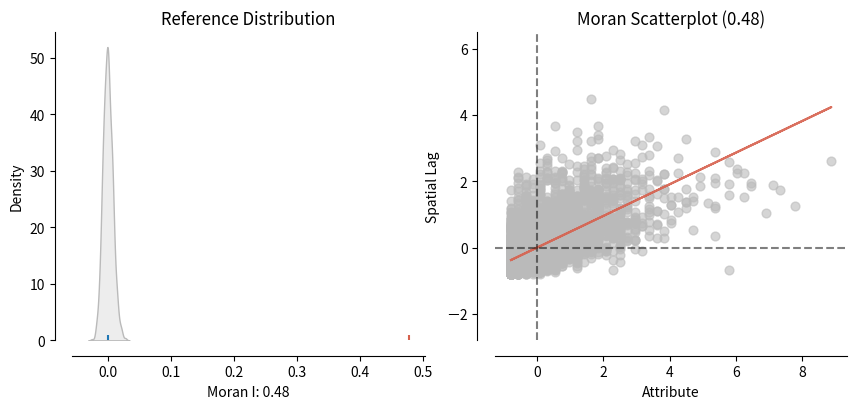

In [16]:
# @title <介面> 繪製 Moran Plot：比較每區與平均 & 鄰居

from ipywidgets import IntText, Dropdown, Button, Output, VBox
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import seaborn
from libpysal import weights

# ✅ 互動元件：最近鄰居數與轉換方式
knn_input = IntText(
    value=6,
    description='最近鄰居數：',
    style={'description_width': 'initial'}
)

transform_widget = Dropdown(
    options=[
        ("R - Row-standardized（行標準化）", "R"),
        ("B - Binary（0/1）", "B"),
        ("D - Inverse Distance（距離倒數）", "D"),
        ("U - Row-sum Unstandardized（原始加總）", "U"),
        ("V - Variance-stabilizing", "V"),
        ("O - Original（不處理）", "O")
    ],
    value="R",
    description="轉換方式：",
    style={'description_width': 'initial'}
)

# ✅ 按鈕與輸出區
execute_button = Button(
    description='確定',
    button_style='primary'
)

output_widget = Output()

# ✅ 顯示介面
display(VBox([
    knn_input,
    transform_widget,
    execute_button,
    output_widget
]))

# ✅ 點擊後執行分析
def on_execute_click(b):
    selected_k = knn_input.value
    selected_transform = transform_widget.value

    with output_widget:
        clear_output(wait=True)

        # -----------------------------------------------

        print(f"最近鄰居數：{selected_k}")
        print(f"轉換方式：{selected_transform}")

        # ✅ 計算與平均值的差異
        db[ANALYSIS_FIELD_NAME_STD] = db[ANALYSIS_FIELD_NAME] - db[ANALYSIS_FIELD_NAME].mean()

        # ✅ 建立空間權重矩陣
        w = weights.KNN.from_dataframe(db, k=selected_k)
        w.transform = selected_transform

        # ✅ 計算與鄰居平均的差異
        db[ANALYSIS_FIELD_NAME_LAG_STD] = weights.lag_spatial(w, db[ANALYSIS_FIELD_NAME_STD])

        # -----------------------------------------------

        # ✅ 繪製 Moran Plot
        f, ax = plt.subplots(1, figsize=(6, 6))
        seaborn.regplot(
            x=ANALYSIS_FIELD_NAME_STD,
            y=ANALYSIS_FIELD_NAME_LAG_STD,
            ci=None,
            data=db,
            line_kws={"color": "r"},
        )
        ax.axvline(0, c="k", alpha=0.5)
        ax.axhline(0, c="k", alpha=0.5)
        ax.set_title(f"Moran Plot - {ANALYSIS_FIELD_NAME}")

        # -----------------------------------------------

        plt.tight_layout()
        plt.show()

        # -----------------------------------------------

        moran = esda.moran.Moran(db[ANALYSIS_FIELD_NAME], w)

        print(f"moran.I: {moran.I}") # Moran’s I 是 +0.45 → 表示值有空間聚集現象（高跟高、低跟低會在一起）
        print(f"moran.p_sim: {moran.p_sim}") # p 值 = 0.001 → 顯著小於 0.05，結果是統計顯著的

        plot_moran(moran);

# ✅ 綁定事件
execute_button.on_click(on_execute_click)

# ✅ 預設執行一次
on_execute_click(None)


### Geary’s C & Getis and Ord’s G

In [17]:
# @title <介面> 顯示 Geary's C 與 Getis and Ord’s G統計結果

# ✅ 匯入必要套件
from ipywidgets import IntText, RadioButtons, Button, Output, VBox, Dropdown # 匯入 RadioButtons
from IPython.display import display, clear_output, HTML # 匯入 HTML，用於顯示臨時訊息
from libpysal import weights
import esda
import pandas as pd # 匯入 pandas，因為計算 Getis-Ord G 需要用到 centroid 和 DataFrame

# ---
# 請確保 db (GeoDataFrame) 和 ANALYSIS_FIELD_NAME (分析欄位名稱) 已經定義。
# 範例資料載入 (請解除註解並替換成你的實際資料):
# import geopandas as gpd
# db = gpd.read_file(gpd.datasets.get_path('nybb')) # 載入一個範例 GeoDataFrame (紐約行政區)
# ANALYSIS_FIELD_NAME = "POP_SQMI" # 替換為你的分析欄位名稱 (例如人口密度、犯罪率等)
# db = db.to_crs("EPSG:3857") # 建議轉換為 Web Mercator 投影座標系，因為 contextily 通常在此 CRS 下表現良好

# ---
# ✅ UI 元件：最近鄰居數、轉換方式、分析類型
knn_input = IntText(
    value=6,
    description='最近鄰居數：',
    style={'description_width': 'initial'}
)

transform_widget = Dropdown(
    options=[
        ("R - Row-standardized（行標準化）", "R"),
        ("B - Binary（0/1）", "B"),
        ("D - Inverse Distance（距離倒數）", "D"),
        ("U - Row-sum Unstandardized（原始加總）", "U"),
        ("V - Variance-stabilizing", "V"),
        ("O - Original（不處理）", "O")
    ],
    value="R",
    description="轉換方式：",
    style={'description_width': 'initial'}
)

# 修正：將分析類型從 Dropdown 改為 RadioButtons
analysis_type_widget = RadioButtons(
    options=[
        ("Geary's C 統計量 (全域)", "GearyC"),
        ("Getis-Ord G 統計量 (全域)", "GetisG")
    ],
    value="GearyC", # 預設顯示 Geary's C
    description="分析類型：",
    style={'description_width': 'initial'}
)

# ✅ 執行按鈕與輸出區
execute_button = Button(
    description='確定',
    button_style='primary',
    icon='chart-line'
)

output_widget = Output()

# ✅ 顯示 UI
display(VBox([
    knn_input,
    transform_widget,
    analysis_type_widget, # 新增分析類型選擇
    execute_button,
    output_widget
]))

# ---
# ✅ 點擊後執行空間統計分析
def on_execute_click(b):
    selected_k = knn_input.value
    selected_transform = transform_widget.value
    selected_analysis_type = analysis_type_widget.value # 獲取選擇的分析類型

    with output_widget:
        clear_output(wait=True)
        # 顯示「計算中」訊息
        display(HTML("<b>計算中，請稍候...</b>"))

        # 檢查地理空間資料 db 是否已載入
        if 'db' not in globals() or db is None:
            clear_output() # 清除載入中訊息
            print("錯誤：請先載入地理空間資料 (db) 並定義 ANALYSIS_FIELD_NAME！")
            return

        # 檢查 ANALYSIS_FIELD_NAME 是否存在於 db 中
        if ANALYSIS_FIELD_NAME not in db.columns:
            clear_output()
            print(f"錯誤：資料框 'db' 中找不到分析欄位 '{ANALYSIS_FIELD_NAME}'。請檢查欄位名稱或載入的資料。")
            return

        # --- 根據選擇的分析類型執行對應的計算 ---
        if selected_analysis_type == "GearyC":
            # Geary's C 統計量計算流程
            print(f"--- 執行 Geary's C 統計分析 ---")
            print(f"最近鄰居數：{selected_k}")
            print(f"轉換方式：{selected_transform}")

            # 建立空間權重矩陣 (Geary's C 需要)
            # Geary's C 對於距離型權重或連續型變數通常效果較好
            w = weights.KNN.from_dataframe(db, k=selected_k)
            w.transform = selected_transform

            # 計算 Geary’s C
            geary = esda.geary.Geary(db[ANALYSIS_FIELD_NAME], w)

            # --- 顯示 Geary's C 統計結果 ---
            clear_output() # 清除「計算中」訊息
            print("--- Geary's C 統計結果 ---")
            print(f"Geary's C 值（geary.C）：{geary.C:.4f}")
            print(f"模擬 p 值（geary.p_sim）：{geary.p_sim:.4f}")

            # --- 解釋 Geary's C 結果 ---
            if geary.C < 1 and geary.p_sim < 0.05:
                print("✅ 結果顯著：存在**正向空間自相關**（鄰近值傾向相似）")
                print("   這表示高值區域周圍傾向於有高值，低值區域周圍傾向於有低值。")
            elif geary.C > 1 and geary.p_sim < 0.05:
                print("⚠️ 結果顯著：存在**負向空間自相關**（鄰近值傾向不同）")
                print("   這表示高值區域周圍傾向於有低值，低值區域周圍傾向於有高值。")
            else:
                print("❓ 結果不顯著：無明顯空間關聯性，可能是隨機分布")
                print("   Geary's C 值接近 1 或 p 值不顯著，表示數據在空間上可能是隨機分佈的。")

        elif selected_analysis_type == "GetisG":
            # Getis-Ord G 統計量計算流程
            print(f"--- 執行 Getis-Ord G 統計分析 ---")

            # 將 GeoDataFrame 轉換為適合距離計算的投影座標系 (例如 TWD97 / EPSG:3826)
            # 這是因為距離計算通常需要在投影座標系下進行，而非經緯度座標系
            db_osgb = db.to_crs(epsg=3826)

            # 從每個區塊的幾何中心點提取 X、Y 座標
            pts = db_osgb.centroid
            xys = pd.DataFrame({"X": pts.x, "Y": pts.y})

            # 計算讓每個點至少有一個鄰居的最小距離門檻
            # 這有助於確保每個點在距離權重矩陣中至少有一個鄰居
            min_thr = weights.util.min_threshold_distance(xys)
            print(f"鄰居的最小距離門檻：{min_thr:.2f} 公尺") # 顯示為公尺，保留兩位小數

            # 根據 min_thr 建立一個距離型空間權重矩陣：
            # 每個點會把「某個距離範圍內的點」當作自己的鄰居
            # 超過這個距離的點，則不視為鄰居（權重為 0）
            w_db = weights.DistanceBand.from_dataframe(db_osgb, min_thr)
            # Geary's C 的轉換方式 (selected_transform) 不適用於 Getis-Ord G 的距離權重，
            # 因此這裡不應用 w_db.transform = selected_transform

            # 計算 Getis and Ord’s G (全域 G 統計量)
            # 默認情況下，esda.getisord.G 會執行模擬來計算 p_sim 和 z_sim
            gao = esda.getisord.G(db[ANALYSIS_FIELD_NAME], w_db)

            # --- 顯示 Getis-Ord G 統計結果 ---
            clear_output() # 清除「計算中」訊息
            print("--- Getis-Ord G 統計結果 ---")
            print(f"Getis and Ord’s G 值（gao.G）：{gao.G:.4f}")
            print(f"模擬 p 值（gao.p_sim）：{gao.p_sim:.4f}")
            print(f"模擬 Z 值（gao.z_sim）：{gao.z_sim:.4f}") # 顯示 Z 值

            # --- 解釋 Getis-Ord G 結果 ---
            # 使用模擬 p 值判斷顯著性，使用模擬 Z 值判斷方向（高值聚集或低值聚集）
            if gao.p_sim < 0.05:
                if gao.z_sim > 0: # Z 值大於 0 表示高值聚集
                    print("✅ 結果顯著：存在**高值空間集群（熱點）**")
                    print("   這表示在空間上，數據的高值傾向於聚集在一起。")
                else: # Z 值小於 0 表示低值聚集
                    print("✅ 結果顯著：存在**低值空間集群（冷點）**")
                    print("   這表示在空間上，數據的低值傾向於聚集在一起。")
            else:
                print("❓ 結果不顯著：無明顯高值或低值集群，可能是隨機分佈")
                print("   Getis-Ord G 值不顯著，表示高值或低值的聚集可能是隨機發生的。")

# ---
# ✅ 綁定事件
execute_button.on_click(on_execute_click)

# ✅ 預設執行一次 (顯示 Geary's C 結果)
on_execute_click(None)